In [57]:
#Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import figure

import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

In [37]:
train_data = pickle.load(open('clean_dataset_2022/train_set.bin', 'rb'))

test_data = pickle.load(open('clean_dataset_2022/test_set.bin', 'rb'))

In [70]:
province = ['BKK','CNX','KKC','RAY','SARA','SURAT']
exog_columns = ['Temp', 'WindSpeed', 'WindDir']

In [83]:
bkk_train = pd.read_csv('clean_dataset_2022/BKK/bkk_train.csv', parse_dates=['Time'], index_col='Time')
cnx_train = pd.read_csv('clean_dataset_2022/Chiangmai/cnx_train.csv', parse_dates=['Time'], index_col='Time')
kkc_train = pd.read_csv('clean_dataset_2022/Khonkaen/kkc_train.csv', parse_dates=['Time'], index_col='Time')
ray_train = pd.read_csv('clean_dataset_2022/Rayong/ray_train.csv', parse_dates=['Time'], index_col='Time')
sara_train = pd.read_csv('clean_dataset_2022/Saraburi/sara_train.csv', parse_dates=['Time'], index_col='Time')
surat_train = pd.read_csv('clean_dataset_2022/Surat/surat_train.csv', parse_dates=['Time'], index_col='Time')

bkk_test = pd.read_csv('clean_dataset_2022/BKK/bkk_test.csv', parse_dates=['Time'], index_col='Time')
cnx_test = pd.read_csv('clean_dataset_2022/Chiangmai/cnx_test.csv', parse_dates=['Time'], index_col='Time')
kkc_test = pd.read_csv('clean_dataset_2022/Khonkaen/kkc_test.csv', parse_dates=['Time'], index_col='Time')
ray_test = pd.read_csv('clean_dataset_2022/Rayong/ray_test.csv', parse_dates=['Time'], index_col='Time')
sara_test = pd.read_csv('clean_dataset_2022/Saraburi/sara_test.csv', parse_dates=['Time'], index_col='Time')
surat_test = pd.read_csv('clean_dataset_2022/Surat/surat_test.csv', parse_dates=['Time'], index_col='Time')

In [328]:
bkk_train = bkk_train.resample('6H').mean()
cnx_train = cnx_train.resample('6H').mean()
kkc_train = kkc_train.resample('6H').mean()
ray_train = ray_train.resample('6H').mean()
sara_train = sara_train.resample('6H').mean()
surat_train = surat_train.resample('6H').mean()


tmp_df = bkk_test.copy()
tmp_df['PM25'] = bkk_test['PM25'].asfreq(freq='6H')
bkk_test = bkk_test.resample('6H').mean()
bkk_test['PM25'] = tmp_df['PM25']

tmp_df = cnx_train.copy()
tmp_df['PM25'] = cnx_train['PM25'].asfreq(freq='6H')
cnx_train = cnx_train.resample('6H').mean()
cnx_train['PM25'] = tmp_df['PM25']

tmp_df = kkc_train.copy()
tmp_df['PM25'] = kkc_train['PM25'].asfreq(freq='6H')
kkc_train = kkc_train.resample('6H').mean()
kkc_train['PM25'] = tmp_df['PM25']

tmp_df = ray_train.copy()
tmp_df['PM25'] = ray_train['PM25'].asfreq(freq='6H')
ray_train = ray_train.resample('6H').mean()
ray_train['PM25'] = tmp_df['PM25']

tmp_df = sara_train.copy()
tmp_df['PM25'] = sara_train['PM25'].asfreq(freq='6H')
sara_train = sara_train.resample('6H').mean()
sara_train['PM25'] = tmp_df['PM25']

tmp_df = surat_train.copy()
tmp_df['PM25'] = surat_train['PM25'].asfreq(freq='6H')
surat_train = surat_train.resample('6H').mean()
surat_train['PM25'] = tmp_df['PM25']

In [329]:
bkk_train.shape * 6

(4384, 5)

In [102]:
# Dickey-Fuller Test
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

## Bangkok

Text(0.5, 1.0, 'Distribution of PM25')

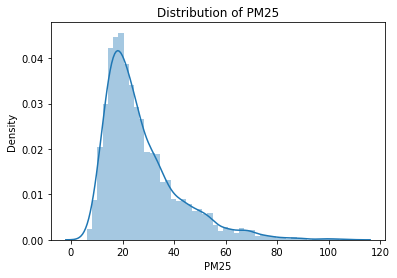

In [134]:
sns.distplot(bkk_train['PM25'])
plt.title('Distribution of PM25')
# plt.savefig('DistributionPassengers.jpg')

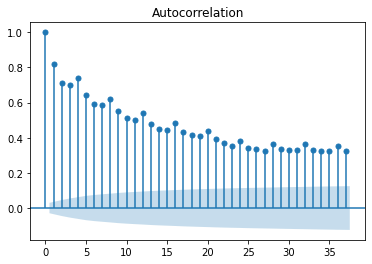

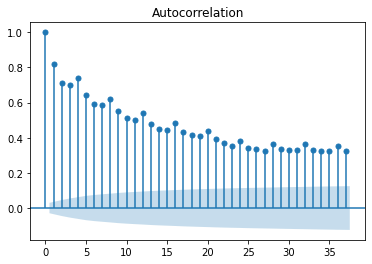

In [135]:
plot_acf(bkk_train['PM25'])

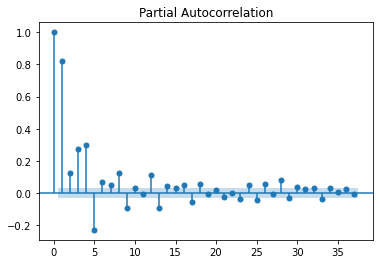

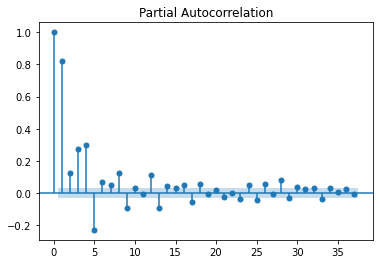

In [136]:
plot_pacf(bkk_train['PM25'])

#### Dickey-Fuller Test

In [137]:
print(interpret_dftest(adfuller(bkk_train['PM25'])),"\n")

print(interpret_dftest(adfuller(bkk_train['PM25'].diff().diff().dropna())),"\n")

Test Statistic   -5.723572e+00
p-value           6.852495e-07
dtype: float64 

Test Statistic   -22.400042
p-value            0.000000
dtype: float64 



<AxesSubplot:xlabel='Time'>

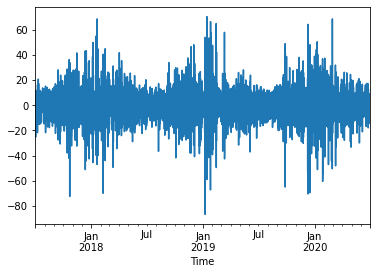

In [138]:
difference_df=bkk_train['PM25'].diff().diff().dropna()
difference_df.plot()
# plt.savefig('Difference.jpg')

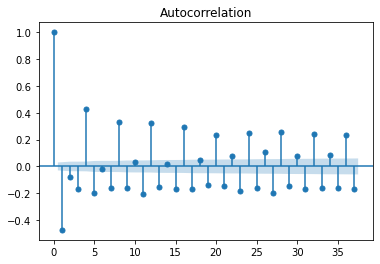

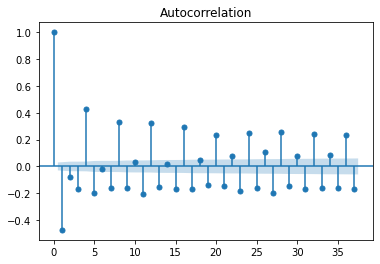

In [139]:
plot_acf(difference_df)
# plt.savefig('2_ACF.jpg');
# MA terms (q=2)

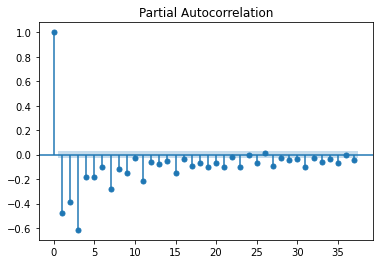

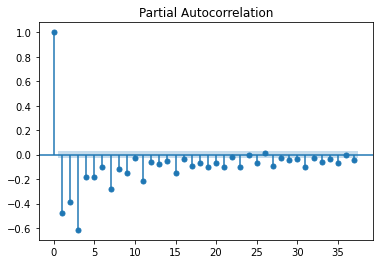

In [140]:
plot_pacf(difference_df)
# plt.savefig('2_PACF.jpg');
# AR terms(p= 0)

In [141]:
df_bkk = pd.concat([bkk_train['PM25'],bkk_test['PM25']])

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df_bkk)

(0.01, False)

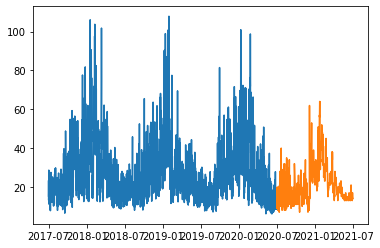

In [142]:
train = bkk_train['PM25']
test = bkk_test['PM25']
plt.plot(train)
plt.plot(test)

In [327]:
# Compute Seasonal Index
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# multiplicative seasonal component
result_mul_train = seasonal_decompose(bkk_train["PM25"][:],
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index_train = result_mul_train.seasonal[-4:].to_frame()
seasonal_index_train['6hour'] = pd.to_datetime(seasonal_index_train.index).hour


# merge with the base data
bkk_train['6hour'] = bkk_train.index.hour
df_train = pd.merge(bkk_train, seasonal_index_train, how='left', on='6hour')
df_train.columns = ['PM25', '6hour', 'Temp', 'WindSpeed', 'WindDir', 'seasonal_index']
df_train.index = bkk_train.index  # reassign the index.

# multiplicative seasonal component
result_mul_test = seasonal_decompose(bkk_test["PM25"][:],
                                model='multiplicative', 
                                extrapolate_trend='freq')

seasonal_index_test = result_mul_test.seasonal[-4:].to_frame()
seasonal_index_test['6hour'] = pd.to_datetime(seasonal_index_test.index).hour


# merge with the base data
bkk_test['6hour'] = bkk_test.index.hour
df_test = pd.merge(bkk_test, seasonal_index_test, how='left', on='6hour')
df_test.columns = ['PM25', '6hour', 'Temp', 'WindSpeed', 'WindDir', 'seasonal_index']
df_test.index = bkk_test.index  # reassign the index.

ValueError: Length mismatch: Expected axis has 4804864 elements, new values have 4384 elements

Time
2020-06-15 00:00:00    0.690332
2020-06-15 06:00:00    0.989321
2020-06-15 12:00:00    1.184635
2020-06-15 18:00:00    0.890122
2020-06-16 00:00:00    0.647291
                         ...   
2020-06-29 18:00:00    0.939682
2020-06-30 00:00:00    1.033235
2020-06-30 06:00:00    1.358383
2020-06-30 12:00:00    1.218763
2020-06-30 18:00:00    0.961465
Freq: 6H, Name: seasonal, Length: 64, dtype: float64

In [260]:
seasonal_index_test

,seasonal,6hour
Time,,
2021-07-01 00:00:00,0.958587,0
2021-07-01 06:00:00,0.963554,6
2021-07-01 12:00:00,1.007846,12
2021-07-01 18:00:00,1.052489,18


In [242]:
bkk_train.shape

(4384, 5)

In [243]:
bkk_test

,Temp,WindSpeed,WindDir,PM25,6hour
Time,,,,,
2020-07-01 00:00:00,28.433333,46.333333,263.333333,9.0,0
2020-07-01 06:00:00,28.966667,52.666667,256.666667,11.0,6
2020-07-01 12:00:00,30.183333,36.666667,271.666667,15.0,12
2020-07-01 18:00:00,29.083333,48.833333,270.833333,14.0,18
2020-07-02 00:00:00,28.500000,42.833333,275.000000,18.0,0
...,...,...,...,...,...
2021-06-30 18:00:00,28.100000,22.000000,260.833333,15.0,18
2021-07-01 00:00:00,27.766667,22.166667,271.666667,15.0,0
2021-07-01 06:00:00,28.350000,20.833333,264.166667,14.0,6


In [320]:
model_bkk = auto_arima(bkk_train[["PM25"]], exogenous=bkk_train[['Temp', 'WindSpeed', 'WindDir']],
                        start_p=0,d=2,start_q=0,
                        max_p=5,max_d=2,max_q=1,start_P=0,
                        D=0, start_Q=0, max_P=1,max_D=1,
                        max_Q=1, max_order=2, m=12, seasonal=True, n_jobs=-1,
                        error_action='warn',trace=True,
                        random=True, supress_warnings=True,stepwise=True,
                        random_state=20, n_fits=5)
                        # exogenous=bkk_train[['Temp', 'WindSpeed', 'WindDir']],

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=35240.910, Time=0.06 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=33731.671, Time=0.62 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=2.66 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=34132.627, Time=0.10 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=33513.975, Time=1.55 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=33810.238, Time=0.61 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=34333.014, Time=1.26 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=32526.275, Time=2.30 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=33071.257, Time=0.81 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=32955.765, Time=0.79 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=33422.821, Time=0.12 sec
 ARIMA(3,2,0)(1,0,1)[12]             : AIC=inf, Time=6.84 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=inf, Time=6.52 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=4.92 sec
 ARIMA(3,2,1)(1,0,1)[12]     

In [321]:
model_bkk.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 4384
Model:             SARIMAX(2, 2, 0)x(1, 0, [1], 12)   Log Likelihood              -16258.137
Date:                              Fri, 25 Mar 2022   AIC                          32526.275
Time:                                      20:54:38   BIC                          32558.201
Sample:                                           0   HQIC                         32537.540
                                             - 4384                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5971      0.009    -66.343      0.000      -0.615      -0.579
ar.L2         -0.4514      0.010    -46.214      0.000      -0.471      -0.432
ar.S.L12       0.9802      0.004    257.602      0.000       0.973       0.988
ma.S.L12      -0.8830      0.008   -104.748      0.000      -0.899      -0.866
sigma2        97.5503      1.179     82.733      0.000      95.239      99.861
===================================================================================
Ljung-Box (L1) (Q):                 226.56   Jarque-Bera (JB):              4056.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -0.57
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [322]:
# Open file - Write binary mode
model_autoARIMA_bkk = open('autoARIMA_save_model/model_autoARIMA_bkk.model', 'wb')

# Save Decision tree model
pickle.dump(model_bkk, model_autoARIMA_bkk)

# Close file
model_autoARIMA_bkk.close()

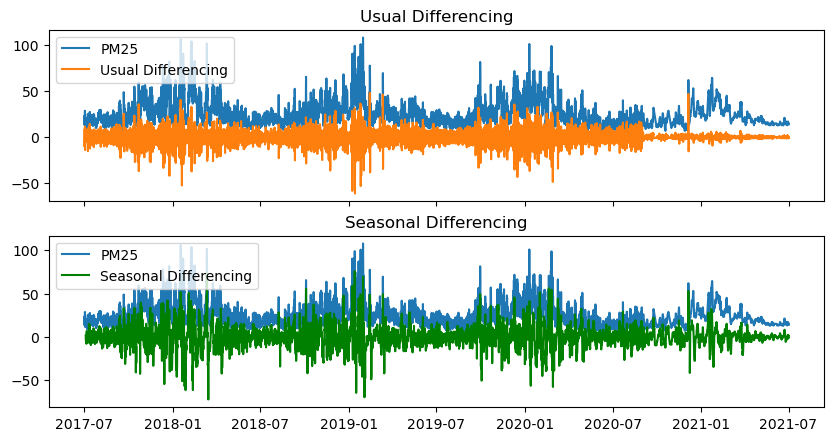

In [323]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df_bkk[:], label='PM25')
axes[0].plot(df_bkk[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasinal Dei
axes[1].plot(df_bkk[:], label='PM25')
axes[1].plot(df_bkk[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
# plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [ ]:
# prediction = pd.DataFrame(model_bkk.predict(n_periods = 12, ), index=test_data['BKK'].index)
# prediction.columns = ['PM25']
# prediction

In [ ]:
fitted, confint = model_bkk.predict(n_periods=4,
                                    X=df_test[['Temp', 'WindSpeed', 'WindDir', 'seasonal_index']][:4],
                                    return_conf_int=True)

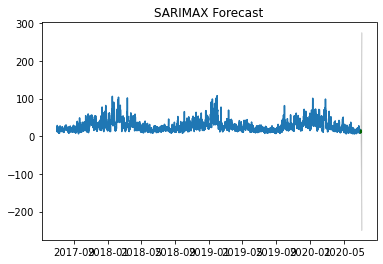

In [324]:
# Forecast

fitted, confint = model_bkk.predict(n_periods = 12, 
                                #   exogenous=df_test[['Temp', 'WindSpeed', 'WindDir',]][:12],
                                  return_conf_int=True)

index_of_fc = pd.date_range(bkk_train.index[-1], periods = 12, freq='6H')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(bkk_train['PM25'])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMAX Forecast")
plt.show()

In [325]:
prediction = pd.DataFrame(model_bkk.predict(4))
prediction.columns = ['PM25']
prediction

,PM25
0,9.067381
1,14.433676
2,15.237114
3,11.718103


In [ ]:
,df_test[['Temp', 'WindSpeed', 'WindDir']][:12]